## 1. Load weld bead dataset

In [70]:
import os
import pandas as pd

In [71]:
data_dir = "../DataSet/BeadSegmentation/mini_data/"
data_df = pd.read_csv(os.path.join(data_dir, "train.csv"))
data_df.head()

,ImageId,MaskId
0,20230930_21h03m03s_B01_1.png,20230930_21h03m03s_B01_1_mask.png
1,20230930_21h03m03s_B01_2.png,20230930_21h03m03s_B01_2_mask.png
2,20230930_21h03m06s_B02_1.png,20230930_21h03m06s_B02_1_mask.png
3,20230930_21h03m06s_B02_2.png,20230930_21h03m06s_B02_2_mask.png
4,20230930_21h03m06s_B02_3.png,20230930_21h03m06s_B02_3_mask.png


In [72]:
data_df.shape

(48, 2)

In [73]:
data_df.head(50)

,ImageId,MaskId
0,20230930_21h03m03s_B01_1.png,20230930_21h03m03s_B01_1_mask.png
1,20230930_21h03m03s_B01_2.png,20230930_21h03m03s_B01_2_mask.png
2,20230930_21h03m06s_B02_1.png,20230930_21h03m06s_B02_1_mask.png
3,20230930_21h03m06s_B02_2.png,20230930_21h03m06s_B02_2_mask.png
4,20230930_21h03m06s_B02_3.png,20230930_21h03m06s_B02_3_mask.png
5,20230930_21h03m06s_B02_4.png,20230930_21h03m06s_B02_4_mask.png
6,20230930_21h03m09s_B03_1.png,20230930_21h03m09s_B03_1_mask.png
7,20230930_21h03m09s_B03_2.png,20230930_21h03m09s_B03_2_mask.png
8,20230930_21h03m09s_B03_3.png,20230930_21h03m09s_B03_3_mask.png
9,20230930_21h03m09s_B03_4.png,20230930_21h03m09s_B03_4_mask.png


In [74]:
def extract_bead_id(x):
    return x.split(".")[0]

In [75]:
data_df["Id"] = data_df.ImageId.apply(lambda x:extract_bead_id(x))
data_df

,ImageId,MaskId,Id
0,20230930_21h03m03s_B01_1.png,20230930_21h03m03s_B01_1_mask.png,20230930_21h03m03s_B01_1
1,20230930_21h03m03s_B01_2.png,20230930_21h03m03s_B01_2_mask.png,20230930_21h03m03s_B01_2
2,20230930_21h03m06s_B02_1.png,20230930_21h03m06s_B02_1_mask.png,20230930_21h03m06s_B02_1
3,20230930_21h03m06s_B02_2.png,20230930_21h03m06s_B02_2_mask.png,20230930_21h03m06s_B02_2
4,20230930_21h03m06s_B02_3.png,20230930_21h03m06s_B02_3_mask.png,20230930_21h03m06s_B02_3
5,20230930_21h03m06s_B02_4.png,20230930_21h03m06s_B02_4_mask.png,20230930_21h03m06s_B02_4
6,20230930_21h03m09s_B03_1.png,20230930_21h03m09s_B03_1_mask.png,20230930_21h03m09s_B03_1
7,20230930_21h03m09s_B03_2.png,20230930_21h03m09s_B03_2_mask.png,20230930_21h03m09s_B03_2
8,20230930_21h03m09s_B03_3.png,20230930_21h03m09s_B03_3_mask.png,20230930_21h03m09s_B03_3
9,20230930_21h03m09s_B03_4.png,20230930_21h03m09s_B03_4_mask.png,20230930_21h03m09s_B03_4


In [76]:
import numpy as np

In [77]:
# check for duplicate IDs

bead_ids = np.unique(data_df.Id.values)
print(len(bead_ids))

48


In [78]:
bead_ids

array(['20230930_21h03m03s_B01_1', '20230930_21h03m03s_B01_2',
       '20230930_21h03m06s_B02_1', '20230930_21h03m06s_B02_2',
       '20230930_21h03m06s_B02_3', '20230930_21h03m06s_B02_4',
       '20230930_21h03m09s_B03_1', '20230930_21h03m09s_B03_2',
       '20230930_21h03m09s_B03_3', '20230930_21h03m09s_B03_4',
       '20230930_21h03m13s_B04_1', '20230930_21h03m13s_B04_2',
       '20230930_21h03m13s_B04_3', '20230930_21h03m13s_B04_4',
       '20230930_21h03m16s_B05_1', '20230930_21h03m16s_B05_2',
       '20230930_21h03m16s_B05_3', '20230930_21h03m16s_B05_4',
       '20230930_21h03m20s_B06_1', '20230930_21h03m20s_B06_2',
       '20230930_21h03m20s_B06_3', '20230930_21h03m20s_B06_4',
       '20230930_21h03m24s_B07_1', '20230930_21h03m24s_B07_2',
       '20230930_21h03m31s_B08_1', '20230930_21h03m31s_B08_2',
       '20230930_21h03m31s_B08_3', '20230930_21h03m31s_B08_4',
       '20230930_21h03m35s_B09_1', '20230930_21h03m35s_B09_2',
       '20230930_21h03m35s_B09_3', '20230930_21h03m35s_

In [79]:
index = 0
bead_data = data_df[data_df.Id == bead_ids[index]][["ImageId", "MaskId"]]

In [80]:
bead_data

,ImageId,MaskId
0,20230930_21h03m03s_B01_1.png,20230930_21h03m03s_B01_1_mask.png


In [81]:
import cv2
import matplotlib.pyplot as plt

In [82]:
sub_index = 0
img_name, mask_name = bead_data.iloc[sub_index].values
img_path, mask_path = os.path.join(data_dir, "images", img_name), os.path.join(data_dir, "masks", mask_name)
image = cv2.imread(img_path)
mask = cv2.imread(mask_path)

In [83]:
np.unique(mask) # Check whether the mask pixel values are binarized

array([  0, 255], dtype=uint8)

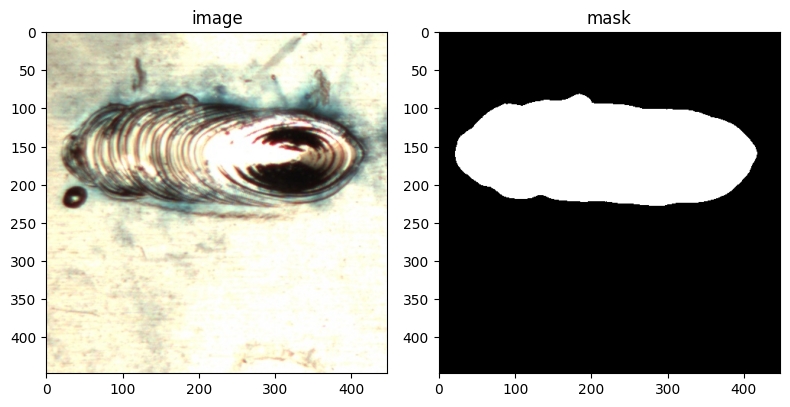

In [84]:
# # In our bead mask, it is not necessary.
# thres = 240     # When input is received in JPG format, there is a loss at the boundary areas, so binarization is performed to clarify the boundaries.
# mask[mask < thres] = 0          
# mask[mask >= thres] = 255

plt.figure(figsize=(8,6))
plt.subplot(121)
plt.title("image")
plt.imshow(image)
plt.subplot(122)
plt.title("mask")
plt.imshow(mask)
plt.tight_layout()

In [85]:
def get_bead_data(data_df, index):
    bead_ids = np.unique(data_df.Id.values)
    bead_id = bead_ids[index]
    bead_data = data_df[data_df.Id == bead_id]
    image_files = list(bead_data["ImageId"])
    mask_files = list(bead_data["MaskId"])
    return bead_id, image_files, mask_files

In [86]:
regions = ["background", "bead"]
colors = ((0,0,0), (255, 255, 255))

In [87]:
def display_bead_dataset(data_df, data_dir, regions, colors, index=0, image_size=448, wait_time=10000):
    bead_id, image_files, mask_files = get_bead_data(data_df, index)

    canvas = np.zeros(shape=(image_size, 2*image_size+50, 3), dtype=np.uint8)
    window_name = 'Bead DataSet'
    cv2.namedWindow(window_name, cv2.WINDOW_NORMAL)

    for i in range(len(image_files)):
        image = cv2.imread(os.path.join(data_dir, "images", image_files[i]))
        if image is None:
            continue
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        mask = cv2.imread(os.path.join(data_dir, "masks", mask_files[i]))
        if mask is None:
            continue
        mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)
        
        grid_pad = 50
        canvas[:, :image_size, :] = image
        canvas[:, image_size+grid_pad:2*image_size+grid_pad, :] = mask
        
        text_buff = 210
        for j in range(1, len(regions)):
            cv2.putText(canvas, f'{regions[j].upper()}', (900, text_buff), cv2.FONT_HERSHEY_SIMPLEX, 1, colors[j], 2)
            text_buff += 40
        
        cv2.imshow(window_name, canvas)
        key = cv2.waitKey(wait_time)
        if key == 27:  # ESC key
            break
        if cv2.getWindowProperty(window_name, cv2.WND_PROP_VISIBLE) < 1:  
            break

    cv2.destroyAllWindows()

# This function encapsulates the updated display mechanism. 
# It checks for the ESC key and window close event to exit. 
# Function calls are commented out to prevent execution at this stage.


In [88]:
# display_bead_dataset(data_df, data_dir, ["region1", "region2"], [(255,0,0), (0,255,0)], index=0, image_size=448, wait_time=10000)

## 2. Build tensor module

In [89]:
# import os
# import shutil
# import numpy as np
# from sklearn.model_selection import train_test_split

# def prepare_dataset(data_dir):
#     images_dir = os.path.join(data_dir, "images")
#     masks_dir = os.path.join(data_dir, "masks")
    
#     # Get list of all images and masks
#     image_files = [f for f in os.listdir(images_dir) if f.endswith('.jpg')]
#     mask_files = [f for f in os.listdir(masks_dir) if f.endswith('.jpg')]

#     # Ensure corresponding images and masks have the same order
#     image_files.sort()
#     mask_files.sort()
    
#     # Split data into training and validation sets
#     train_images, val_images, train_masks, val_masks = train_test_split(
#         image_files, mask_files, test_size=0.1, random_state=42)
    
#     # Create directories for training and validation sets
#     train_img_dir = os.path.join(data_dir, 'train', 'images')
#     train_mask_dir = os.path.join(data_dir, 'train', 'masks')
#     val_img_dir = os.path.join(data_dir, 'val', 'images')
#     val_mask_dir = os.path.join(data_dir, 'val', 'masks')
    
#     for d in [train_img_dir, train_mask_dir, val_img_dir, val_mask_dir]:
#         os.makedirs(d, exist_ok=True)
    
#     # Function to copy files to new destination
#     def copy_files(files, source_dir, target_dir):
#         for f in files:
#             shutil.copy(os.path.join(source_dir, f), os.path.join(target_dir, f))
    
#     # Copy images and masks to respective directories
#     copy_files(train_images, images_dir, train_img_dir)
#     copy_files(train_masks, masks_dir, train_mask_dir)
#     copy_files(val_images, images_dir, val_img_dir)
#     copy_files(val_masks, masks_dir, val_mask_dir)

#     return train_img_dir, train_mask_dir, val_img_dir, val_mask_dir

# # Note: The function call is commented out to avoid execution at this stage. This code assumes the data directory structure and availability.
# # prepare_dataset('/path/to/data')


In [90]:
# data_dir = "../DataSet/BeadSegmentation/"
# prepare_dataset(data_dir)

In [91]:
import torch

In [92]:
IMAGE_SIZE = 224    # U-net input image size: 224*224

In [93]:
import os
import shutil
import cv2
import numpy as np
import torch
from sklearn.model_selection import train_test_split

class bead_dataset():
    def __init__(self, data_dir, phase, transformer=None, split_ratio=0.1):
        self.phase = phase
        self.root_dir = data_dir
        # self.data_dir = os.path.join(data_dir, "original_data")  # 원본 데이터 폴더
        self.data_dir = os.path.join(data_dir, "mini_data")  # 원본 데이터 폴더
        self.images_dir = os.path.join(data_dir, phase, "images")
        self.masks_dir = os.path.join(data_dir, phase, "masks")

        # 원본 데이터 폴더 확인 및 train/val 데이터 폴더 생성
        self.prepare_data_folders(split_ratio)
        
        # 이미지와 마스크 파일 목록 로드
        self.image_files = [filename for filename in os.listdir(self.images_dir) if filename.endswith("png")]
        self.mask_files = [filename for filename in os.listdir(self.masks_dir) if filename.endswith("png")]
        assert len(self.image_files) == len(self.mask_files), "The number of images and masks must be the same."

        self.transformer = transformer

    def prepare_data_folders(self, split_ratio):
        original_images = [f for f in os.listdir(os.path.join(self.data_dir, "images")) if f.endswith('png')]
        original_masks = [f for f in os.listdir(os.path.join(self.data_dir, "masks")) if f.endswith('png')]

        # 데이터 분할
        train_images, val_images = train_test_split(original_images, test_size=split_ratio, random_state=42)

        # 폴더 경로 설정
        train_images_dir = os.path.join(self.root_dir, "train", "images")
        train_masks_dir = os.path.join(self.root_dir, "train", "masks")
        val_images_dir = os.path.join(self.root_dir, "val", "images")
        val_masks_dir = os.path.join(self.root_dir, "val", "masks")

        # 필요한 경우 폴더 생성
        for directory in [train_images_dir, train_masks_dir, val_images_dir, val_masks_dir]:
            os.makedirs(directory, exist_ok=True)
        
        # 이미지와 마스크 파일 복사
        for img_list, img_dir, mask_dir in [(train_images, train_images_dir, train_masks_dir), (val_images, val_images_dir, val_masks_dir)]:
            for img in img_list:
                shutil.copy(os.path.join(self.data_dir, "images", img), img_dir)
                
                # 마스크 파일명 추정 및 복사
                mask_name = img[:-4] + '_mask.png'
                if mask_name in original_masks:
                    shutil.copy(os.path.join(self.data_dir, "masks", mask_name), mask_dir)
                else:
                    print(f"Warning: No matching mask file found for {img}")

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, index):
        image = cv2.imread(os.path.join(self.images_dir, self.image_files[index]))
        image = cv2.resize(image, dsize=(IMAGE_SIZE,IMAGE_SIZE), interpolation=cv2.INTER_LINEAR)
        mask = cv2.imread(os.path.join(self.masks_dir, self.mask_files[index]))
        mask = cv2.resize(mask, dsize=(IMAGE_SIZE,IMAGE_SIZE), interpolation=cv2.INTER_NEAREST)
        mask[mask < 240] = 0
        mask[mask >= 240] = 255
        mask = mask / 255

        mask_H, mask_W, mask_C = mask.shape
        background = np.ones((mask_H, mask_W))
        background[mask[...,0] != 0] = 0
        background[mask[...,1] != 0] = 0
        background[mask[...,2] != 0] = 0
        mask = np.concatenate([np.expand_dims(background, -1), mask], axis=-1)
        mask = np.argmax(mask, axis=-1)

        if self.transformer:
            image = self.transformer(image)
        target = torch.from_numpy(mask).long()
        return image, target


In [94]:
from torchvision import transforms

In [95]:
def build_transformer():
    transformer = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # ImageNet의 데이터셋 이미지들의 평균과 표준편차
    ])
    return transformer

In [96]:
def collate_fn(batch):
    images = []
    targets = []
    for a, b in batch:
        images.append(a)
        targets.append(b)
    images = torch.stack(images, dim=0)
    targets = torch.stack(targets, dim=0)

    return images, targets

In [97]:
from torch.utils.data import DataLoader

In [98]:
data_dir = "../DataSet/BeadSegmentation/"
transformer = build_transformer()
tr_dataset = bead_dataset(data_dir=data_dir, phase="train", transformer=transformer)
val_dataset = bead_dataset(data_dir=data_dir, phase="val", transformer=transformer)
tr_dataloader = DataLoader(tr_dataset, batch_size=4, shuffle=True, collate_fn=collate_fn)
val_dataloader = DataLoader(val_dataset, batch_size=1, shuffle=False, collate_fn=collate_fn)

In [99]:
# Check out dataset, execution can be omitted
image, target = tr_dataset[0]
print(f"Image Shape: {image.shape}")
print(f"Target Shape: {target.shape}")

Image Shape: torch.Size([3, 224, 224])
Target Shape: torch.Size([224, 224])


In [100]:
def build_dataloader(data_dir, batch_size=4):
    transformer = build_transformer()

    dataloaders = {}
    train_dataset = bead_dataset(data_dir=data_dir, phase="train", transformer=transformer)
    dataloaders["train"] = DataLoader(tr_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)

    val_dataset = bead_dataset(data_dir=data_dir, phase="val", transformer=transformer)
    dataloaders["val"] = DataLoader(val_dataset, batch_size=1, shuffle=False, collate_fn=collate_fn)
    return dataloaders

In [101]:
# Check the dataloader, execution can be omitted

data_dir = "../DataSet/BeadSegmentation/"
dataloaders = build_dataloader(data_dir=data_dir)

for phase in ["train", "val"]:
    for index, batch in enumerate(dataloaders[phase]):
        images = batch[0]
        targets = batch[1]
        print(f"{phase} images shape: {images.shape}")
        print(f"{phase} masks shape: {targets.shape}")

        if index == 0:
            break

train images shape: torch.Size([4, 3, 224, 224])
train masks shape: torch.Size([4, 224, 224])
val images shape: torch.Size([1, 3, 224, 224])
val masks shape: torch.Size([1, 224, 224])


## 3. Construct U-Net architecture

In [102]:
import torch
import torch.nn as nn

In [103]:
# conv 3*3, ReLU
def ConvLayer(in_channels, out_channels):
    layers = nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True),

        nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True),
    )
    return layers

In [104]:
class Encoder(nn.Module):
    def __init__(self):
        super().__init__()      # super()는 nn.Module을 상속받아 사용한다는 뜻
        self.conv_block1 = ConvLayer(in_channels=3, out_channels=64)
        self.conv_block2 = ConvLayer(in_channels=64, out_channels=128)
        self.conv_block3 = ConvLayer(in_channels=128, out_channels=256)
        self.conv_block4 = ConvLayer(in_channels=256, out_channels=512)
        self.conv_block5 = ConvLayer(in_channels=512, out_channels=1024)
        self.pool = nn.MaxPool2d(kernel_size=2)

    def forward(self, x):
        encode_features = []        # skip connection을 위해 feature를 저장
        out = self.conv_block1(x)
        encode_features.append(out)
        out = self.pool(out)

        out = self.conv_block2(out)
        encode_features.append(out)
        out = self.pool(out)

        out = self.conv_block3(out)
        encode_features.append(out)
        out = self.pool(out)

        out = self.conv_block4(out)
        encode_features.append(out)
        out = self.pool(out)

        out = self.conv_block5(out)
        return out, encode_features

In [105]:
encoder = Encoder()
x = torch.randn(1, 3, 224, 224)
out, ftrs = encoder(x)

In [106]:
for ftr in ftrs:
    print(ftr.shape)
print(out.shape)

torch.Size([1, 64, 224, 224])
torch.Size([1, 128, 112, 112])
torch.Size([1, 256, 56, 56])
torch.Size([1, 512, 28, 28])
torch.Size([1, 1024, 14, 14])


In [107]:
def UpConvLayer(in_channels, out_channels):
    layers = nn.Sequential(
        nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True)
    )
    return layers

In [108]:
class Decoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.upconv_layer1 = UpConvLayer(in_channels=1024, out_channels=512)
        self.conv_block1 = ConvLayer(in_channels=512+512, out_channels=512)

        self.upconv_layer2 = UpConvLayer(in_channels=512, out_channels=256)
        self.conv_block2 = ConvLayer(in_channels=256+256, out_channels=256)

        self.upconv_layer3 = UpConvLayer(in_channels=256, out_channels=128)
        self.conv_block3 = ConvLayer(in_channels=128+128, out_channels=128)

        self.upconv_layer4 = UpConvLayer(in_channels=128, out_channels=64)
        self.conv_block4 = ConvLayer(in_channels=64+64, out_channels=64)

    def forward(self, x, encoder_features):
        out = self.upconv_layer1(x)
        croped_enc_feature = self._center_crop(encoder_features[-1], out.shape[2:])
        out = torch.cat([out, croped_enc_feature], dim=1)
        out = self.conv_block1(out)

        out = self.upconv_layer2(out)
        croped_enc_feature = self._center_crop(encoder_features[-2], out.shape[2:])
        out = torch.cat([out, croped_enc_feature], dim=1)
        out = self.conv_block2(out)

        out = self.upconv_layer3(out)
        croped_enc_feature = self._center_crop(encoder_features[-3], out.shape[2:])
        out = torch.cat([out, croped_enc_feature], dim=1)
        out = self.conv_block3(out)

        out = self.upconv_layer4(out)
        croped_enc_feature = self._center_crop(encoder_features[-4], out.shape[2:])
        out = torch.cat([out, croped_enc_feature], dim=1)
        out = self.conv_block4(out)
        return out

    def _center_crop(self, encoder_feature, decoder_feature_size):
        croped_features = transforms.CenterCrop(size=decoder_feature_size)(encoder_feature)
        return croped_features

In [109]:
encoder = Encoder()
decoder = Decoder()
x = torch.randn(1, 3, 224, 224)
out, ftrs = encoder(x)
out = decoder(out, ftrs)

In [110]:
print(out.shape)

torch.Size([1, 64, 224, 224])


In [111]:
import torch.nn.functional as F

In [112]:
class UNet(nn.Module):
    def __init__(self, num_classes, retain_input_dim=True):
        super().__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()
        self.head = nn.Conv2d(64, num_classes, kernel_size=1)
        self.retain_input_dim = retain_input_dim

    def forward(self, x):
        out, encode_features = self.encoder(x)
        out = self.decoder(out, encode_features)
        out = self.head(out)
        if self.retain_input_dim:
            _, _, H, W = x.shape
            out = F.interpolate(out, size=(H,W))
        return out

In [113]:
model = UNet(num_classes=2)     # Two classes including Background
x = torch.randn(1, 3, 224, 224)
out = model(x)
print(f"input shape: {x.shape}")
print(f"output shape: {out.shape}")

input shape: torch.Size([1, 3, 224, 224])
output shape: torch.Size([1, 2, 224, 224])


## 4. Implement dice similarity coefficient

In [114]:
for index, batch in enumerate(tr_dataloader):
    images = batch[0]
    targets = batch[1]
    predictions = model(images)

    if index == 0:
        break

In [115]:
targets.shape

torch.Size([4, 224, 224])

In [116]:
predictions.shape

torch.Size([4, 2, 224, 224])

In [117]:
num_classes = 2

predictions_ = torch.argmax(predictions, dim=1)
onehot_pred = F.one_hot(predictions_, num_classes=num_classes).permute(0, 3, 1, 2)
onehot_target = F.one_hot(targets, num_classes=num_classes).permute(0, 3, 1, 2)

In [118]:
onehot_pred_ = onehot_pred[0]
onehot_target_ = onehot_target[0]

dice_coeff = 0
for class_index in range(1, num_classes):
    a = onehot_pred_[class_index]
    b = onehot_target_[class_index]
    set_inter = torch.dot(a.reshape(-1).float(), b.reshape(-1).float())
    set_sum = a.sum() + b.sum()
    dice_coeff += (2 * set_inter) / (set_sum + 1e-9)
dice_coeff /= (num_classes-1)

In [119]:
dice_coeff

tensor(0.3644)

In [120]:
dice_loss = 1. - dice_coeff

In [121]:
class UNet_metric():
    def __init__(self, num_classes):
        self.num_classes = num_classes

    def __call__(self, pred, target):
        onehot_pred = F.one_hot(torch.argmax(pred, dim=1), num_classes=self.num_classes).permute(0, 3, 1, 2)
        onehot_target = F.one_hot(target, num_classes=self.num_classes).permute(0, 3, 1, 2)
        dice_loss = self._get_dice_loss(onehot_pred, onehot_target)
        dice_coefficient = self._get_batch_dice_coefficient(onehot_pred, onehot_target)
        return dice_loss, dice_coefficient

    def _get_dice_coeffient(self, pred, target):
        set_inter = torch.dot(pred.reshape(-1).float(), target.reshape(-1).float())
        set_sum = pred.sum() + target.sum()
        if set_sum.item() == 0:
            set_sum = 2 * set_inter
        dice_coeff = (2 * set_inter) / (set_sum + 1e-9)
        return dice_coeff

    def _get_multiclass_dice_coefficient(self, pred, target):
        dice = 0
        for class_index in range(1, self.num_classes):
            dice += self._get_dice_coeffient(pred[class_index], target[class_index])
        return dice / (self.num_classes - 1)

    def _get_batch_dice_coefficient(self, pred, target):
        num_batch = pred.shape[0]
        dice = 0
        for batch_index in range(num_batch):
            dice += self._get_multiclass_dice_coefficient(pred[batch_index], target[batch_index])
        return dice / num_batch

    def _get_dice_loss(self, pred, target):
        return 1 - self._get_batch_dice_coefficient(pred, target)

In [122]:
criterion = UNet_metric(num_classes=2)
criterion(predictions, targets)

(tensor(0.6731), tensor(0.3269))

## 5. Implement Loss function and optimizer 

In [123]:
class UNet_metric():
    def __init__(self, num_classes):
        self.num_classes = num_classes
        self.CE_loss = nn.CrossEntropyLoss(reduction="mean")    # 배치에 대한 CrossEntroyLoss를 추가, reductino="mean"은 로스를 배치의 크기로 나눈 것이 아니라 엘리먼트들의 갯수로 나눈 것임
                                                                # reduction="none"

                                                                # reduction="sum"
                                                                # loss /= batch_size
                                                                # 등이 있으니 reduction 방법을 확인해서 loss값이 발산하는 것을 방지해야 함
    def __call__(self, pred, target):
        onehot_pred = F.one_hot(torch.argmax(pred, dim=1), num_classes=self.num_classes).permute(0, 3, 1, 2)
        onehot_target = F.one_hot(target, num_classes=self.num_classes).permute(0, 3, 1, 2)
        
        loss1 = self.CE_loss(pred, target)                          # crossentropyloss
        loss2 = self._get_dice_loss(onehot_pred, onehot_target)     # diceloss
        loss = loss1 + loss2

        dice_coefficient = self._get_batch_dice_coefficient(onehot_pred, onehot_target)
        return loss, dice_coefficient

    def _get_dice_coeffient(self, pred, target):
        set_inter = torch.dot(pred.reshape(-1).float(), target.reshape(-1).float())
        set_sum = pred.sum() + target.sum()
        if set_sum.item() == 0:
            set_sum = 2 * set_inter
        dice_coeff = (2 * set_inter) / (set_sum + 1e-9)
        return dice_coeff

    def _get_multiclass_dice_coefficient(self, pred, target):
        dice = 0
        for class_index in range(1, self.num_classes):              # 0은 background에 대한 것으로 학습할 필요가 없음
            dice += self._get_dice_coeffient(pred[class_index], target[class_index])
        return dice / (self.num_classes - 1)

    def _get_batch_dice_coefficient(self, pred, target):
        num_batch = pred.shape[0]
        dice = 0
        for batch_index in range(num_batch):
            dice += self._get_multiclass_dice_coefficient(pred[batch_index], target[batch_index])
        return dice / num_batch

    def _get_dice_loss(self, pred, target):
        return 1 - self._get_batch_dice_coefficient(pred, target)

In [124]:
criterion = UNet_metric(num_classes=2)
criterion(predictions, targets)

(tensor(1.4492, grad_fn=<AddBackward0>), tensor(0.3269))

In [125]:
for index, batch in enumerate(dataloaders["train"]):
    images = batch[0]
    targets = batch[1]
    predictions = model(images)
    loss, dice_coeff = criterion(predictions, targets)
    print(f"Loss:{loss:.4f}, dice coeff: {dice_coeff:.4f}")

    if index == 1:
        break

Loss:1.4226, dice coeff: 0.3588
Loss:1.4629, dice coeff: 0.3253


In [126]:
loss.backward()     # Check if the backward gradient update is working properly

In [127]:
optimizer = torch.optim.SGD(model.parameters(), lr= 1E-3, momentum=0.9)

In [128]:
optimizer.step()    # Check the operation of the optimizer.

In [129]:
for index, batch in enumerate(tr_dataloader):
    images = batch[0]
    targets = batch[1]
    predictions = model(images)
    criterion(predictions, targets)
    if index == 1:
        break

## 6. Implement code for semantic segmentation training

In [130]:
def train_one_epoch(dataloaders, model, optimizer, criterion, device):
    losses = {}
    dice_coefficients = {}

    for phase in ["train", "val"]:
        running_loss = 0.0
        running_dice_coeff = 0.0

        if phase == "train":
            model.train()
        else:
            model.eval()

        for index, batch in enumerate(dataloaders[phase]):
            images = batch[0].to(device)
            targets = batch[1].to(device)

            with torch.set_grad_enabled(phase == "train"):
                predictions = model(images)
                loss, dice_coefficient = criterion(predictions, targets)

                if phase == "train":
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()

            running_loss += loss.item()
            running_dice_coeff += dice_coefficient.item()

            if phase == "train":
                if index % 100 == 0:
                    text = f"{index}/{len(dataloaders[phase])}" + \
                            f" - Running Loss: {loss.item():.4f}" + \
                            f" - Running Dice: {dice_coefficient.item():.4f}"
                    print(text)

        losses[phase] = running_loss / len(dataloaders[phase])
        dice_coefficients[phase] = running_dice_coeff / len(dataloaders[phase])
    return losses, dice_coefficients

In [131]:
from utils import save_model        # utils.py: save the best model

In [132]:
import torch

# GPU 사용 가능 -> True, GPU 사용 불가 -> False
print(torch.cuda.is_available())

# GPU 사용 가능 -> 가장 빠른 번호 GPU, GPU 사용 불가 -> CPU 자동 지정 예시
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')

# GPU 이름 체크(cuda:0에 연결된 그래픽 카드 기준)
print(torch.cuda.get_device_name(device = 0)) 

# 사용 가능 GPU 개수 체크
print(torch.cuda.device_count()) # 3

True
NVIDIA GeForce RTX 4090
2


In [133]:
# # 특정 번호의 GPU 사용 지정
# # 만일, 특정 번호(들)의 GPU만을 파이토치에서 사용하고 싶은 경우는 os 모듈의 기능을 활용하여 다음 코드처럼 지정
# # 여러개의 GPU를 연결한 경우, 그래픽 카드가 연결된 순서대로 각각
# # cuda:0, cuda:1, ... 디바이스로 인식되도록 지정

# import os

# # 0, 1, 2번의 GPU를 모두 사용하고 싶은 경우 예시(각각 cuda:0, cuda:1, cuda:2에 지정)
# os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
# os.environ["CUDA_VISIBLE_DEVICES"] = "0,1,2"

# # 2번 GPU만 사용하고 싶은 경우 예시(cuda:0에 지정)
# os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
# os.environ["CUDA_VISIBLE_DEVICES"] = "2"

In [134]:
# PyTorch에서의 다중 GPU 설정 방법

# # 1. 모델을 DataParallel로 감싸기
# import torch
# import torch.nn as nn

# model = MyModel()  # 모델 인스턴스 생성
# if torch.cuda.is_available():
#     model = model.cuda()  # 모델을 GPU로 이동
#     model = nn.DataParallel(model)  # 모델을 여러 GPU에 분산

# # 2. 입력 데이터 배치를 GPU에 적절히 할당하기
# for data, target in dataloader:
#     if torch.cuda.is_available():
#         data, target = data.cuda(), target.cuda()
#     output = model(data)  # 병렬 처리된 모델에 데이터를 전달
#     loss = loss_function(output, target)  # 손실 계산
#     # 역전파 및 최적화 진행
#     optimizer.zero_grad()
#     loss.backward()
#     optimizer.step()

# # 3. 환경 설정 확인
# # 모든 GPU가 제대로 인식되고 있는지 확인하고, 필요한 라이브러리와 드라이버가 최신 상태인지 검사
# # 터미널에서 nvidia-smi를 실행하여 GPU 상태를 확인

In [135]:
data_dir = "../DataSet/BeadSegmentation/"
is_cuda = True

NUM_CLASSES = 2
IMAGE_SIZE = 224
# BATCH_SIZE = 2
BATCH_SIZE = 12
DEVICE = torch.device('cuda' if torch.cuda.is_available() and is_cuda else 'cpu')

dataloaders = build_dataloader(data_dir, batch_size=BATCH_SIZE)
model = UNet(num_classes=NUM_CLASSES)
model = model.to(DEVICE)
criterion = UNet_metric(num_classes=NUM_CLASSES)
optimizer = torch.optim.SGD(model.parameters(), lr= 1E-3, momentum=0.9)
# optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [142]:
import pandas as pd
from datetime import datetime
import os

num_epochs = 200

best_epoch = 0
best_score = 0.0
results = {
    "epoch": [],
    "train_loss": [],
    "val_loss": [],
    "train_dice_coefficient": [],
    "val_dice_coefficient": []
}

# 'summary' 폴더 생성
summary_folder = 'summary'
os.makedirs(summary_folder, exist_ok=True)

for epoch in range(num_epochs):
    # 가정: train_one_epoch 함수는 딕셔너리 형태로 손실과 Dice 계수를 반환
    losses, dice_coefficients = train_one_epoch(dataloaders, model, optimizer, criterion, DEVICE)
    results["epoch"].append(epoch)
    results["train_loss"].append(losses["train"])
    results["val_loss"].append(losses["val"])
    results["train_dice_coefficient"].append(dice_coefficients["train"])
    results["val_dice_coefficient"].append(dice_coefficients["val"])

    print(f"{epoch}/{num_epochs} - Train Loss: {losses['train']:.4f}, Val Loss: {losses['val']:.4f}")
    print(f"{epoch}/{num_epochs} - Train Dice Coeff: {dice_coefficients['train']:.4f}, Val Dice Coeff: {dice_coefficients['val']:.4f}")

    if (epoch > 5) and (dice_coefficients["val"] > best_score):
        best_epoch = epoch
        best_score = dice_coefficients["val"]
        save_model(model.state_dict(), os.path.join(summary_folder, f"model_{epoch:02d}.pth"))

# 데이터를 DataFrame으로 변환하고 CSV 파일로 저장
df = pd.DataFrame(results)
current_time = datetime.now().strftime("%Y%m%d_%H%M%S")
csv_file_path = os.path.join(summary_folder, f"training_results_{current_time}.csv")
df.to_csv(csv_file_path, index=False)

print(f"Best epoch: {best_epoch} -> Best Dice Coefficient: {best_score:.4f}")


0/4 - Running Loss: 1.0721 - Running Dice: 0.3369
0/200 - Train Loss: 1.1648, Val Loss: 1.0868
0/200 - Train Dice Coeff: 0.2892, Val Dice Coeff: 0.3540
0/4 - Running Loss: 1.3069 - Running Dice: 0.1940
1/200 - Train Loss: 1.1578, Val Loss: 1.0956
1/200 - Train Dice Coeff: 0.2930, Val Dice Coeff: 0.3439
0/4 - Running Loss: 1.0261 - Running Dice: 0.3783
2/200 - Train Loss: 1.1480, Val Loss: 1.0765
2/200 - Train Dice Coeff: 0.3052, Val Dice Coeff: 0.3600
0/4 - Running Loss: 1.1873 - Running Dice: 0.2788
3/200 - Train Loss: 1.1246, Val Loss: 1.1057
3/200 - Train Dice Coeff: 0.3160, Val Dice Coeff: 0.3321
0/4 - Running Loss: 1.0893 - Running Dice: 0.3358
4/200 - Train Loss: 1.1545, Val Loss: 1.1034
4/200 - Train Dice Coeff: 0.2922, Val Dice Coeff: 0.3349
0/4 - Running Loss: 1.0729 - Running Dice: 0.3491
5/200 - Train Loss: 1.1234, Val Loss: 1.0972
5/200 - Train Dice Coeff: 0.3113, Val Dice Coeff: 0.3414
0/4 - Running Loss: 1.0728 - Running Dice: 0.3486
6/200 - Train Loss: 1.1341, Val Loss: 

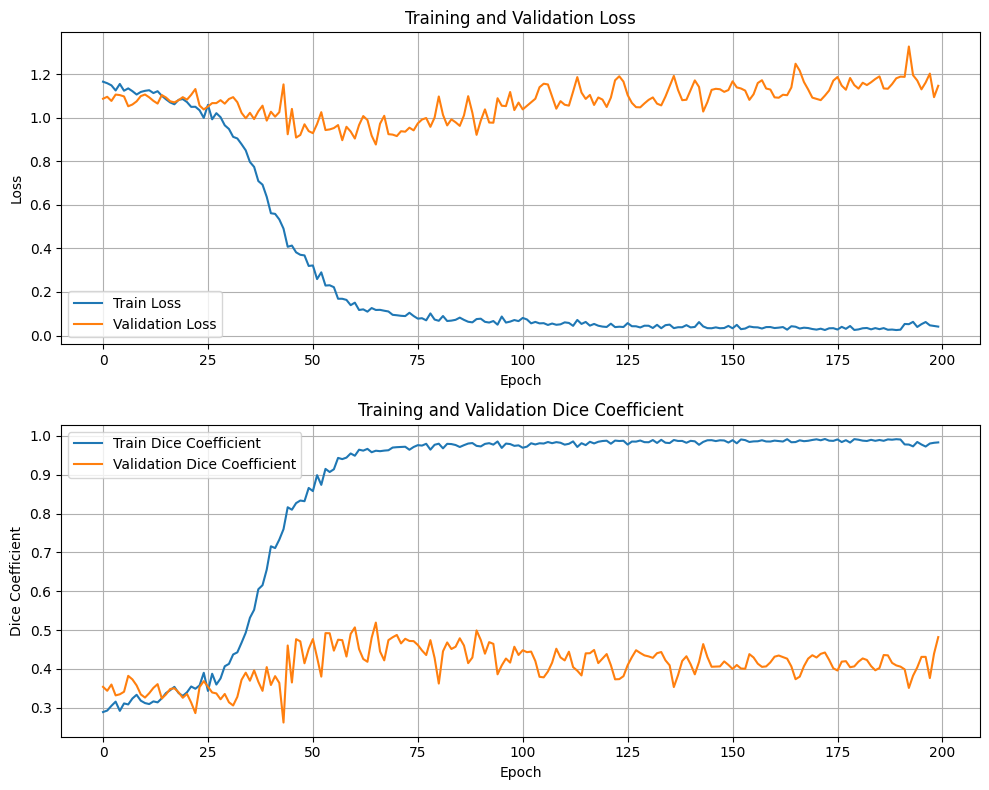

In [143]:
import matplotlib.pyplot as plt

# 결과 딕셔너리에서 데이터 추출
epoch = results["epoch"]
train_loss = results["train_loss"]
val_loss = results["val_loss"]
train_dice_coefficient = results["train_dice_coefficient"]
val_dice_coefficient = results["val_dice_coefficient"]

# 손실 그래프
plt.figure(figsize=(10, 8))
plt.subplot(211)
plt.plot(epoch, train_loss, label="Train Loss")
plt.plot(epoch, val_loss, label="Validation Loss")
plt.title("Training and Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.legend()

# Dice 계수 그래프
plt.subplot(212)
plt.plot(epoch, train_dice_coefficient, label="Train Dice Coefficient")
plt.plot(epoch, val_dice_coefficient, label="Validation Dice Coefficient")
plt.title("Training and Validation Dice Coefficient")
plt.xlabel("Epoch")
plt.ylabel("Dice Coefficient")
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()


## 7. Model Test

In [144]:
import os
import cv2
import torch
import numpy as np
from torchvision import transforms
from torch.utils.data import DataLoader
from ipywidgets import interact, IntSlider
import matplotlib.pyplot as plt

def load_model(ckpt_path, num_classes, device):
    checkpoint = torch.load(ckpt_path, map_location=device)
    model = UNet(num_classes=num_classes)
    model.load_state_dict(checkpoint)
    model = model.to(device)
    model.eval()        # 테스트를 위해 evaluation 모드를 사용
    return model



def test_model_interactive(index, data_dir, ckpt_path, num_classes, device='cuda'):
    images_dir = os.path.join(data_dir, 'val', 'images')
    masks_dir = os.path.join(data_dir, 'val', 'masks')
    image_files = sorted([f for f in os.listdir(images_dir) if f.endswith('.png')])
    
    if index < 0 or index >= len(image_files):
        print("Invalid index. Please choose an index within the range of the dataset.")
        return

    image_path = os.path.join(images_dir, image_files[index])
    mask_path = os.path.join(masks_dir, image_files[index][:-4] + '_mask.png')

    # 이미지 로드 및 전처리
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (IMAGE_SIZE, IMAGE_SIZE))
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    input_tensor = transform(image).unsqueeze(0).to(device)

    # 모델 로드 및 예측
    model = load_model(ckpt_path, num_classes, device)
    with torch.no_grad():
        output = model(input_tensor)
        predicted_mask = torch.argmax(output, dim=1).squeeze().cpu().numpy()
        predicted_mask = cv2.cvtColor((predicted_mask * 255).astype(np.uint8), cv2.COLOR_GRAY2BGR)

    # 실제 마스크 로드 및 차원 변환
    true_mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    true_mask = cv2.resize(true_mask, (IMAGE_SIZE, IMAGE_SIZE))
    true_mask = cv2.cvtColor(true_mask, cv2.COLOR_GRAY2BGR)

    # 이미지, 실제 마스크, 예측 마스크 표시
    plt.figure(figsize=(18, 6))
    plt.subplot(1, 3, 1)
    plt.imshow(image)
    plt.title('Original Image')
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(true_mask)
    plt.title('Ground Truth Mask')
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(predicted_mask)
    plt.title('Predicted Mask')
    plt.axis('off')
    plt.show()


In [145]:
data_dir = "../DataSet/BeadSegmentation/"
ckpt_path = "/home/club8080/Downloads/trained_model/summary/model_65.pth"

num_files = len(os.listdir(os.path.join(data_dir, 'val', 'images')))  # 이미지 개수 확인

from ipywidgets import interact, fixed
import matplotlib.pyplot as plt

# 이전의 함수 정의는 그대로 유지

# interact를 사용하여 인터랙티브 요소 추가
interact(test_model_interactive, 
         index=IntSlider(min=0, max=num_files-1, step=1, value=0),
         data_dir=fixed(data_dir),
         ckpt_path=fixed(ckpt_path),
         num_classes=fixed(2),
         device=fixed('cuda'))


interactive(children=(IntSlider(value=0, description='index', max=42), Output()), _dom_classes=('widget-intera…

<function __main__.test_model_interactive(index, data_dir, ckpt_path, num_classes, device='cuda')>

In [126]:
def load_model(ckpt_path, num_classes, device):
    checkpoint = torch.load(ckpt_path, map_location=device)
    model = UNet(num_classes=num_classes)
    model.load_state_dict(checkpoint)
    model = model.to(device)
    model.eval()        # 테스트를 위해 evaluation 모드를 사용
    return model

In [127]:
is_cuda = True

NUM_CLASSES = 2
IMAGE_SIZE = 224
DEVICE = torch.device('cuda' if torch.cuda.is_available and is_cuda else 'cpu')

In [131]:
ckpt_path = "/home/club8080/Downloads/trained_model/summary/model_21.pth"
model = load_model(ckpt_path, NUM_CLASSES, DEVICE)

transformer = transforms.Compose([
            transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

In [132]:
# 결과로 나타는 blob을 제거
# opencv를 사용하여 ksize를 알맞게 조절한다.

def morpholocal_process(mask, num_classes, ksize=7):
    new_mask = mask.copy()
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT,(ksize, ksize))

    for class_index in range(1, num_classes):
        binary_mask = (mask == class_index).astype(np.uint8)
        closing = cv2.morphologyEx(binary_mask, cv2.MORPH_CLOSE, kernel)
        new_mask[closing.astype(np.bool_)] = class_index
    return new_mask

In [133]:
from utils import CLASS_ID_TO_RGB

In [134]:
def decode_segmap(mask, num_classes):
    mask_H, mask_W = mask.shape
    R_channel = np.zeros((mask_H, mask_W), dtype=np.uint8)
    G_channel = np.zeros((mask_H, mask_W), dtype=np.uint8)
    B_channel = np.zeros((mask_H, mask_W), dtype=np.uint8)

    for class_index in range(1, num_classes):
        R_channel[mask == class_index] = CLASS_ID_TO_RGB[class_index][0]
        G_channel[mask == class_index] = CLASS_ID_TO_RGB[class_index][1]
        B_channel[mask == class_index] = CLASS_ID_TO_RGB[class_index][2]

    RGB_mask = cv2.merge((B_channel, G_channel, R_channel))
    return RGB_mask

In [135]:
from PIL import Image

In [136]:
@torch.no_grad()
def predict_segment(image, model, num_classes, device):
    PIL_image = Image.fromarray(image)
    tensor_image = transformer(PIL_image)
    tensor_image = tensor_image.to(device)                      # 텐서 이미지 포맷은 (C, H, W) 채널/높이/폭 형태임

    pred_mask = model(torch.unsqueeze(tensor_image, dim=0))     # 네트워크 입력단은 (B, C, H, W) 와 같이 배치형태로 구성되어 있어야 연산이 되므로 unsqueeze를 함
    pred_mask = torch.argmax(pred_mask.squeeze(0).cpu(), dim=0) # (C, H, W) -> (H, W): 0, 1, 2, 3
    pred_mask = pred_mask.numpy()
    pred_mask = morpholocal_process(pred_mask, num_classes)
    rgb_mask = decode_segmap(pred_mask, num_classes)
    return rgb_mask

In [137]:
import cv2
import os

def images_to_video(image_folder, output_video_path, fps=30):
    # 이미지 파일 목록 가져오기 (예: .png 파일만)
    images = [img for img in os.listdir(image_folder) if img.endswith(".png")]
    images.sort()  # 파일 이름 순으로 정렬

    # 첫 번째 이미지로 비디오의 해상도 결정
    frame = cv2.imread(os.path.join(image_folder, images[0]))
    height, width, layers = frame.shape

    # 비디오 작성자 설정
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # 'mp4v'는 mp4 비디오를 위한 코덱
    video = cv2.VideoWriter(output_video_path, fourcc, fps, (width, height))

    # 각 이미지를 비디오 프레임으로 추가
    for image in images:
        video.write(cv2.imread(os.path.join(image_folder, image)))

    # 비디오 저장 및 자원 해제
    video.release()
    cv2.destroyAllWindows()

# 함수 사용 예
image_folder = '../DataSet/BeadSegmentation/val/images'
output_video_path = '../DataSet/BeadSegmentation/video/val_video.mp4'
images_to_video(image_folder, output_video_path)


In [138]:
video_path = "../DataSet/BeadSegmentation/video/test/val_video.mp4"
cnt = 0
vidcap = cv2.VideoCapture(video_path)
while (vidcap.isOpened()):
    ret, frame = vidcap.read()

    if ret:
        rgb_mask = predict_segment(frame, model, NUM_CLASSES, DEVICE)
        rgb_mask = cv2.resize(rgb_mask, dsize=frame.shape[:2])    # 원본
        # rgb_mask = cv2.resize(rgb_mask, dsize=(frame.shape[1], frame.shape[0])) # 강의 코드 dsize=(W, H)
        alpha = 0.6
        blend = cv2.addWeighted(frame, alpha, rgb_mask, 1-alpha, 0)
        cv2.imshow('output', blend)

        key = cv2.waitKey(1)
        if key == 27:
            break
        if key == ord('s'):     # 영상을 멈출 때 사용
            cv2.waitKey(0)
    else:
        break

vidcap.release()
cv2.destroyAllWindows()

In [139]:
import cv2

video_path = "../DataSet/BeadSegmentation/video/test/val_video.mp4"
vidcap = cv2.VideoCapture(video_path)

while vidcap.isOpened():
    ret, frame = vidcap.read()

    if ret:
        rgb_mask = predict_segment(frame, model, NUM_CLASSES, DEVICE)
        rgb_mask = cv2.resize(rgb_mask, dsize=frame.shape[:2])  # 원본 이미지 크기에 맞춰 마스크 크기 조정

        alpha = 0.6
        blend = cv2.addWeighted(frame, alpha, rgb_mask, 1-alpha, 0)
        cv2.imshow('output', blend)

        while True:  # 무한 루프를 추가하여 Space bar를 기다립니다.
            key = cv2.waitKey(0)  # 키 입력을 무한히 기다립니다.
            if key == 27:  # ESC 키가 눌리면 프로그램 종료
                vidcap.release()
                cv2.destroyAllWindows()
                exit()
            if key == 32:  # Space bar가 눌리면 다음 프레임으로 넘어갑니다.
                break
    else:
        break

vidcap.release()
cv2.destroyAllWindows()
